<h1 style="text-align: center">Twitter Sentiment Analysis</h1>

![](assets/sentiment.png)

<br/>  
### [Everything You Need to Know about Sentiment Analysis](https://monkeylearn.com/sentiment-analysis/)
<br/>

## Twitter datas are too unsructured for machine learning. 
### We have to prepare them to achieve better accuracy at prediction
<br/>

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns; sns.set()

%matplotlib inline

###### The dataset is not in "UTF-8" encoding

In [2]:
train = pd.read_csv("dataset/train.csv", encoding="ISO-8859-1")
test = pd.read_csv("dataset/test.csv", encoding="ISO-8859-1")

##### Import [Contractions](https://stackoverflow.com/a/19794953/8141330)

In [3]:
with open('assets/contractions.json', 'r') as f:
    contractions_dict = json.load(f)
contractions = contractions_dict['contractions']

###### Setting Pandas DataFrame to show non-truncated table

In [4]:
pd.set_option('display.max_colwidth', -1)

##### Printing the dataset

In [5]:
train.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL friend.............
1,2,0,I missed the New Moon trailer...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...
4,5,0,i think mi bf is cheating on me!!! T_T


###### Merging test and train data to preprocess them together

In [6]:
# total_data = train.append(test, ignore_index=True)
total_data = train

##### Taking column names into variables

In [7]:
tweet = train.columns.values[2]
sentiment = train.columns.values[1]

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99989 entries, 0 to 99988
Data columns (total 3 columns):
ItemID           99989 non-null int64
Sentiment        99989 non-null int64
SentimentText    99989 non-null object
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299989 entries, 0 to 299988
Data columns (total 2 columns):
ItemID           299989 non-null int64
SentimentText    299989 non-null object
dtypes: int64(1), object(1)
memory usage: 4.6+ MB


In [10]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99989 entries, 0 to 99988
Data columns (total 3 columns):
ItemID           99989 non-null int64
Sentiment        99989 non-null int64
SentimentText    99989 non-null object
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


<br/>

# 1)  Preprocessing

* **Convert every tweets to lower case**
* **Remove Twitter username**
* **Remove punctuations, numbers and special characters**
* **Convert more than 2 letter repetitions to 2 letter ( example (wooooooow --> woow))**
* **Remove extra spaces**
* **Remove URLs**
* **Emoji analysis**
* **Handle contractions words**
    - **" can't " >> " can not "**
    - **" won't " >> " will not "**
    - **" should't " >> " should not "**
* **(Optional) Remove [Stop words](https://www.geeksforgeeks.org/removing-stop-words-nltk-python/)**
* **(Optional) Tokenization**
* **(Optional) [Stemming](https://www.geeksforgeeks.org/python-stemming-words-with-nltk/)**

`check this to see `**[Live twitter emoji usage](https://emojitracker.com/)**` (the webpage is heroku backed, so it is safe)`

`Check this `**[Stackoverflow answer](https://stackoverflow.com/a/43023503/8141330)**` to know how contraction dictionary of shortened words can be done`

`check this `**[Stackexchange answer](https://datascience.stackexchange.com/questions/15765/nlp-why-is-not-a-stop-word)**` to know why we have to modify stop words`

`check this `**[Stop words for sentiment analysis research paper](http://www.lrec-conf.org/proceedings/lrec2014/pdf/292_Paper.pdf)**` to know why we need specific stop words`


`Problem: This is dataset specific. As this is not in unicode, every (') is replaced with (&quot;) . Click this ` **[Stackoverflow anwser](https://stackoverflow.com/questions/24602154/explain-what-quot-means)** ` to see in details.`

### Import  stemmer, tokenize and stop words which we will use later

In [11]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


# stop_words
# nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gunjan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gunjan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Define a function which handles emoji classifications

In [12]:
def emoji(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :') , :O
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positiveemoji ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positiveemoji ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' positiveemoji ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-; , @-)
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positiveemoji ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:, :-/ , :-|
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negetiveemoji ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' negetiveemoji ', tweet)
    return tweet


###### Define a function which will preprocess the tweets

`We will be using string.split() instead of nltk.tokenize, check this `**[Stackoverflow answer](https://stackoverflow.com/a/35348340/8141330)**` for more information`

In [13]:
import re

def process_tweet(tweet):
    tweet = tweet.lower()                                             # Lowercases the string
    tweet = re.sub('@[^\s]+', '', tweet)                              # Removes usernames
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', tweet)   # Remove URLs
    tweet = re.sub(r"\d+", " ", str(tweet))                           # Removes all digits
    tweet = re.sub('&quot;'," ", tweet)                               # Remove (&quot;) 
    tweet = emoji(tweet)                                              # Replaces Emojis
    tweet = re.sub(r"\b[a-zA-Z]\b", "", str(tweet))                   # Removes all single characters
    for word in tweet.split():
        if word.lower() in contractions:
            tweet = tweet.replace(word, contractions[word.lower()])   # Replaces contractions
#         tweet = tweet.replace(word, stemmer.stem(word))
    tweet = re.sub(r"[^\w\s]", " ", str(tweet))                       # Removes all punctuations
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet)                         # Convert more than 2 letter repetitions to 2 letter
    tweet = re.sub(r"\s+", " ", str(tweet))                           # Replaces double spaces with single space    
    return tweet

###### Now make a new column for side by side comparison of new tweets vs old tweets

`Check this `**[Stackoverflow answer](https://stackoverflow.com/a/52674448/8141330)**` to know how to loop faster in python`

###### Let's compare unprocessed tweets with the processed one

In [14]:
total_data['processed_tweet'] = np.vectorize(process_tweet)(total_data[tweet])

In [15]:
total_data.head()

,ItemID,Sentiment,SentimentText,processed_tweet
0,1,0,is so sad for my APL friend.............,is so sad for my apl friend
1,2,0,I missed the New Moon trailer...,missed the new moon trailer
2,3,1,omg its already 7:30 :O,omg its already
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...,omgaga im soo im gunna cry ve been at this dentist since was suposed just get crown put on mins
4,5,0,i think mi bf is cheating on me!!! T_T,think mi bf is cheating on me t_t


#### Tokenization

In [16]:
tokenized_tweet = total_data['processed_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [is, so, sad, for, my, apl, friend]                                                                                 
1    [missed, the, new, moon, trailer]                                                                                   
2    [omg, its, already]                                                                                                 
3    [omgaga, im, soo, im, gunna, cry, ve, been, at, this, dentist, since, was, suposed, just, get, crown, put, on, mins]
4    [think, mi, bf, is, cheating, on, me, t_t]                                                                          
Name: processed_tweet, dtype: object

#### Stemming

In [17]:
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_tweet.head()

0    [is, so, sad, for, my, apl, friend]                                                                           
1    [miss, the, new, moon, trailer]                                                                               
2    [omg, it, alreadi]                                                                                            
3    [omgaga, im, soo, im, gunna, cri, ve, been, at, thi, dentist, sinc, wa, supos, just, get, crown, put, on, min]
4    [think, mi, bf, is, cheat, on, me, t_t]                                                                       
Name: processed_tweet, dtype: object

#### Stiching

In [18]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

total_data['processed_tweet'] = tokenized_tweet
total_data.head()

,ItemID,Sentiment,SentimentText,processed_tweet
0,1,0,is so sad for my APL friend.............,is so sad for my apl friend
1,2,0,I missed the New Moon trailer...,miss the new moon trailer
2,3,1,omg its already 7:30 :O,omg it alreadi
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...,omgaga im soo im gunna cri ve been at thi dentist sinc wa supos just get crown put on min
4,5,0,i think mi bf is cheating on me!!! T_T,think mi bf is cheat on me t_t


# 2) Most used words

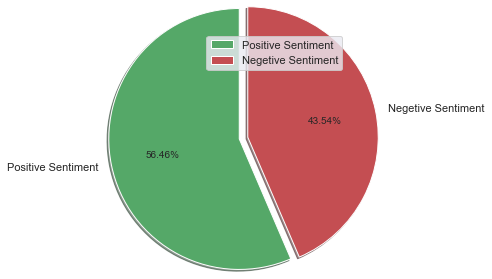

In [19]:
sentiments = ['Positive Sentiment', 'Negetive Sentiment'] 
slices = [(total_data[sentiment] != 0).sum(), (total_data[sentiment] == 0).sum()] 
colors = ['g', 'r'] 
plt.pie(slices, labels = sentiments, colors=colors, startangle=90, shadow = True,
        explode = (0, 0.1), radius = 1.5, autopct = '%1.2f%%') 
plt.legend()
plt.show() 

## 2.2) Most used positive words

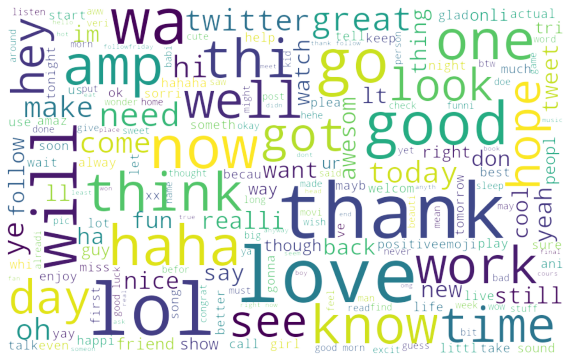

In [32]:
positive_words =' '.join([text for text in total_data['processed_tweet'][total_data[sentiment] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state=21,
            max_font_size=110,background_color="rgba(255, 255, 255, 0)"
            , mode="RGBA").generate(positive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## 2.3) Most used negetive words

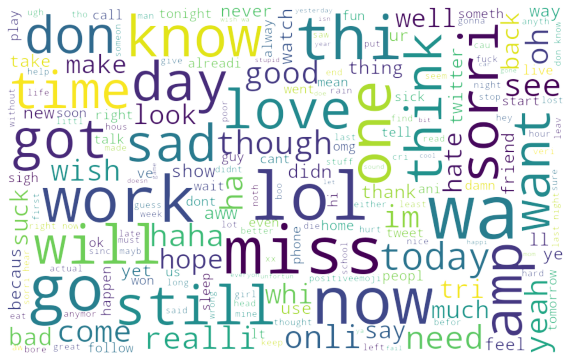

In [21]:
negetive_words =' '.join([text for text in total_data['processed_tweet'][total_data[sentiment] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, 
            max_font_size=110,background_color="rgba(255, 255, 255, 0)"
            , mode="RGBA").generate(negetive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### See the word `lol`. It is used both in positive and negetive(sarcastic) sentiments. We still can't classify sarcasm.

# 3) Feature extraction (vectorization)

`check this article on `**[How to Prepare Text Data for Machine Learning with scikit-learn](https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/)**

## 3.1) Count vectorizer

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
counts = count_vect.fit_transform(total_data['processed_tweet'])  
counts

<99989x38571 sparse matrix of type '<class 'numpy.int64'>'
	with 1077244 stored elements in Compressed Sparse Row format>

## 3.2) Tfi Df vectorizer

In [23]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()
tf_idf = transformer.fit_transform(counts)
tf_idf

<99989x38571 sparse matrix of type '<class 'numpy.float64'>'
	with 1077244 stored elements in Compressed Sparse Row format>

# 4) Splitting

##### Splitting train data to test accuracy

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tf_idf, total_data[sentiment], test_size=0.2, random_state=69)  

##### Printing splitted dataset sizes

In [25]:
print("X_train_shape : ",X_train.shape)
print("X_test_shape : ",X_test.shape)
print("y_train_shape : ",y_train.shape)
print("y_test_shape : ",y_test.shape)

X_train_shape :  (79991, 38571)
X_test_shape :  (19998, 38571)
y_train_shape :  (79991,)
y_test_shape :  (19998,)


# 5) Naive_bayes

### Bayes theorem :
![](assets/bayes_formula.jpg)

## There are some popular classifiers under Naive Bayes
* **Bernoulli Naive Bayes**
* **Gaussian Naive Bayes classifier**
* **Multinomial Naive Bayes**

### We will use Multinomial Naive Bayes classifier

In [26]:
from sklearn.naive_bayes import MultinomialNB 

##### Train the dataset

In [27]:
model = MultinomialNB().fit(X_train, y_train) 
predicted = model.predict(X_test)

##### Find out accuracy of our prediction

In [28]:
from sklearn.metrics import accuracy_score
score = accuracy_score(predicted, y_test)
print("Accuracy : ",score)

Accuracy :  0.7435743574357436


##### Print Confusion matrix

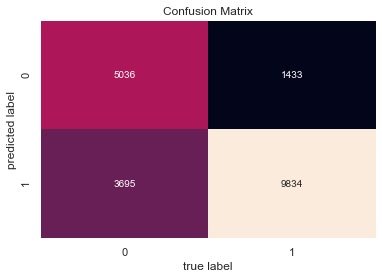

In [29]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test, predicted)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

# 6) Precision, Recall, and Accuracy

##### Precision, recall, and accuracy are standard metrics used to evaluate the performance of a classifier.

* Precision measures how many texts were predicted correctly as belonging to a given category out of all of the texts that were predicted (correctly and incorrectly) as belonging to the category.

* Recall measures how many texts were predicted correctly as belonging to a given category out of all the texts that should have been predicted as belonging to the category. We also know that the more data we feed our classifiers with, the better recall will be.

* Accuracy measures how many texts were predicted correctly (both as belonging to a category and not belonging to the category) out of all of the texts in the corpus.

##### Most frequently, precision and recall are used to measure performance since accuracy alone does not say much about how good or bad a classifier is.

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.78      0.58      0.66      8731
           1       0.73      0.87      0.79     11267

    accuracy                           0.74     19998
   macro avg       0.75      0.72      0.73     19998
weighted avg       0.75      0.74      0.74     19998



# 7) Acknowledgements

#### Datasets taken from
* **[Kaggle Twitter dataset](https://www.kaggle.com/c/twitter-sentiment-analysis2/data)**


#### Must Read
* **[Towards Data Science](https://towardsdatascience.com/creating-the-twitter-sentiment-analysis-program-in-python-with-naive-bayes-classification-672e5589a7ed)**
* **[Analytics Vidya](https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/)**
* **[Project report on Github](https://github.com/abdulfatir/twitter-sentiment-analysis/blob/master/docs/report.pdf)**
* **[Medium](https://medium.com/@martinpella/naive-bayes-for-sentiment-analysis-49b37db18bf8)**
* **[Stackabuse](https://stackabuse.com/the-naive-bayes-algorithm-in-python-with-scikit-learn/)**
* **[Geeksforgeeks](https://www.geeksforgeeks.org/graph-plotting-in-python-set-1/)**